# EDA Notebook

Hello, everybody. This is going to be the EDA Notebook for the second week assignment for the DataGlacier Internship, made by GlenM42. 

To start, let's install all the required libraries, and load the csv files:


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm

cab_data = pd.read_csv('Cab_Data.csv')
print("\nCab Data Preview:")
display(cab_data.head())
city_data = pd.read_csv('City.csv')
print("\nCity Data Preview:")
display(city_data.head())
customer_data = pd.read_csv('Customer_ID.csv')
print("\nCustomer Data Preview:")
display(customer_data.head())
transaction_data = pd.read_csv('Transaction_ID.csv')
print("\nTransaction Data Preview:")
display(transaction_data.head())


Cab Data Preview:


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776



City Data Preview:


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"



Customer Data Preview:


,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536



Transaction Data Preview:


,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


That's great. All the columns and rows provide meaningful results, except for the Date of Travel column in *transaction data*. We would change that in a second, but having a look at the data, we can come up with some questions that our analysis will answer:
- Ultimately, should the XYZ company invest in a cab company or not? Which one?
- Who are the primary customers (what's their gender/age/income)?
- What is the average distance of the trip?
- What is the profit on each customer?
- What is the distribution of preferred payment methods?
- Which company is more profitable?
- How do these parameters change based on regions?
- How do they change based on weather?

Let us change the format of the Date of Travel column.

In [2]:
from datetime import datetime, timedelta

# Function to convert Excel serial date to standard date format
def convert_excel_serial_date(serial_date):
    base_date = datetime(1899, 12, 30)  # This accounts for Excel leap year bug (1900 is treated as a leap year)
    delta = timedelta(days=int(serial_date))
    return base_date + delta

# Apply conversion to the 'Date of Travel' column
cab_data['Date of Travel'] = cab_data['Date of Travel'].apply(convert_excel_serial_date)

# Display the converted date values to verify the changes
print("Converted 'Date of Travel' Preview:")
display(cab_data['Date of Travel'].head())


Converted 'Date of Travel' Preview:


0   2016-01-08
1   2016-01-06
2   2016-01-02
3   2016-01-07
4   2016-01-03
Name: Date of Travel, dtype: datetime64[ns]

## Profitability Analysis

Now that we have everything ready, we can find the profits made with each transaction. The formula for it is going to be simple difference between Price Charged and Cost of Trip.

In [3]:
cab_data['Profit'] = cab_data['Price Charged'] - cab_data['Cost of Trip']
display(cab_data.head())

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844


With that we can group the values for profit by months and by companies in a way that would allow us to easily compare them.

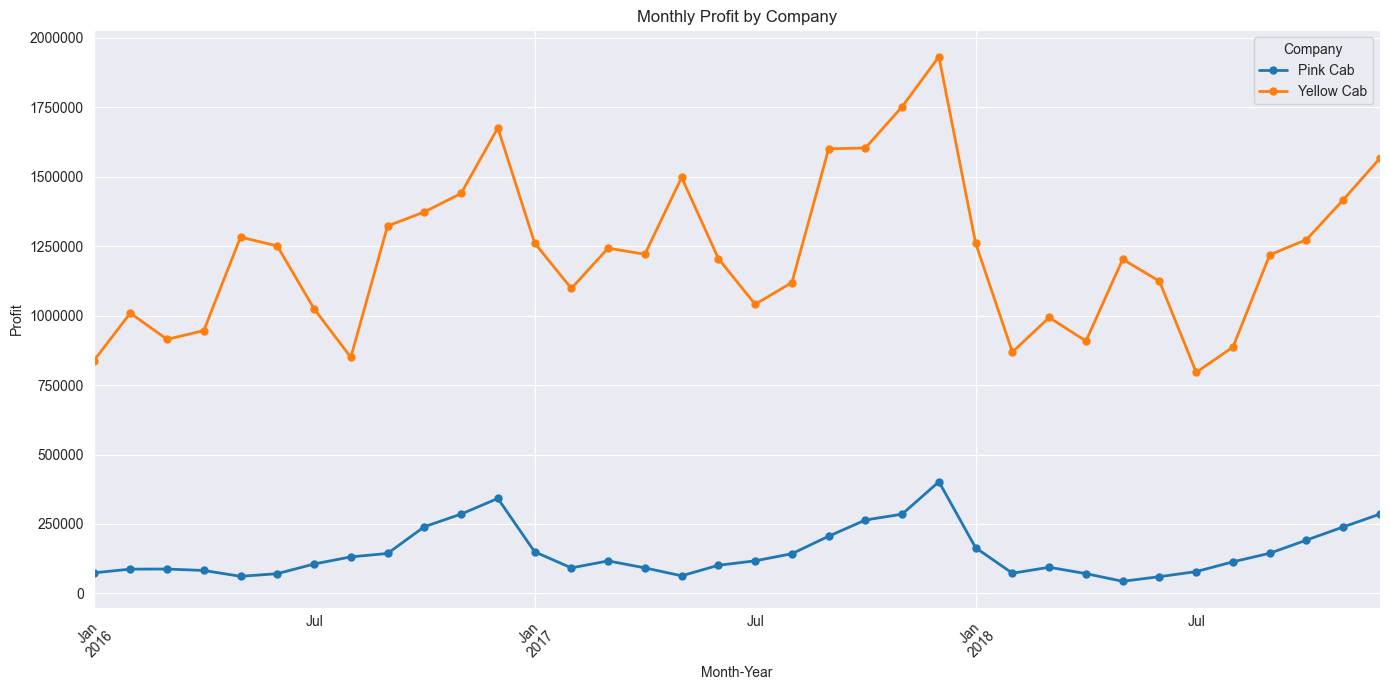

In [4]:
# Function to format the y-axis ticks as plain numbers
def millions_formatter(x, pos):
    return f'{int(x)}'

# Extract year and month from 'Date of Travel' for easier grouping
cab_data['Month-Year'] = cab_data['Date of Travel'].dt.to_period('M')

# Group data by month and company and sum up the profits
monthly_profit = cab_data.groupby(['Month-Year', 'Company'])['Profit'].sum().unstack()

# Plotting the results
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
ax = plt.gca()
monthly_profit.plot(kind='line', marker='o', linestyle='-', linewidth=2, markersize=5, ax=plt.gca())
plt.title('Monthly Profit by Company')
plt.xlabel('Month-Year')
plt.ylabel('Profit')
plt.grid(True)
plt.legend(title='Company')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))  # Apply plain number format
plt.tight_layout()  # Adjust subplots to give some padding between them for axis labels
plt.show()

With this chart we have the most important part figured out. 
- The Pink Company makes significantly less profit than the Yellow Company;
- The Profits of Yellow Company are much more volatile;
- Both companies experience some seasonality, as the profits tend to rise in December.

The new questions we would like to answer are:
- How much more volatile the Yellow Company is?
- What's the average profit per kilometer compare between the companies?
- What are the differences in profit per city?
- Maybe we can forecast the profit values taking into account the seasonality?

### Part I. Differences in Volatility

In [5]:
# Calculate standard deviation of monthly profits for each company
profit_volatility = monthly_profit.std()
print("Volatility in Monthly Profits:")
print(profit_volatility)

Volatility in Monthly Profits:
Company
Pink Cab       90063.965532
Yellow Cab    282089.039256
dtype: float64


### Part II. Difference is average profit per KM or ride

In [6]:
# Group data by company and sum up profits and kilometers traveled
company_aggregates = cab_data.groupby('Company').agg({
    'Profit': 'sum',
    'KM Travelled': 'sum'
})

# Calculate average profit per kilometer for each company
company_aggregates['Profit per KM'] = company_aggregates['Profit'] / company_aggregates['KM Travelled']
print("Average Profit per Kilometer for Each Company:")
print(company_aggregates['Profit per KM'])

Average Profit per Kilometer for Each Company:
Company
Pink Cab      2.777146
Yellow Cab    7.100727
Name: Profit per KM, dtype: float64


In [7]:
# Calculate number of rides per company
company_aggregates['Rides Count'] = cab_data.groupby('Company').size()

# Calculate average profit per ride for each company
company_aggregates['Profit per Ride'] = company_aggregates['Profit'] / company_aggregates['Rides Count']
print("Average Profit per Ride for Each Company:")
print(company_aggregates[['Profit per Ride']])

Average Profit per Ride for Each Company:
            Profit per Ride
Company                    
Pink Cab          62.652174
Yellow Cab       160.259986


### Part III. Geographical analysis of profits

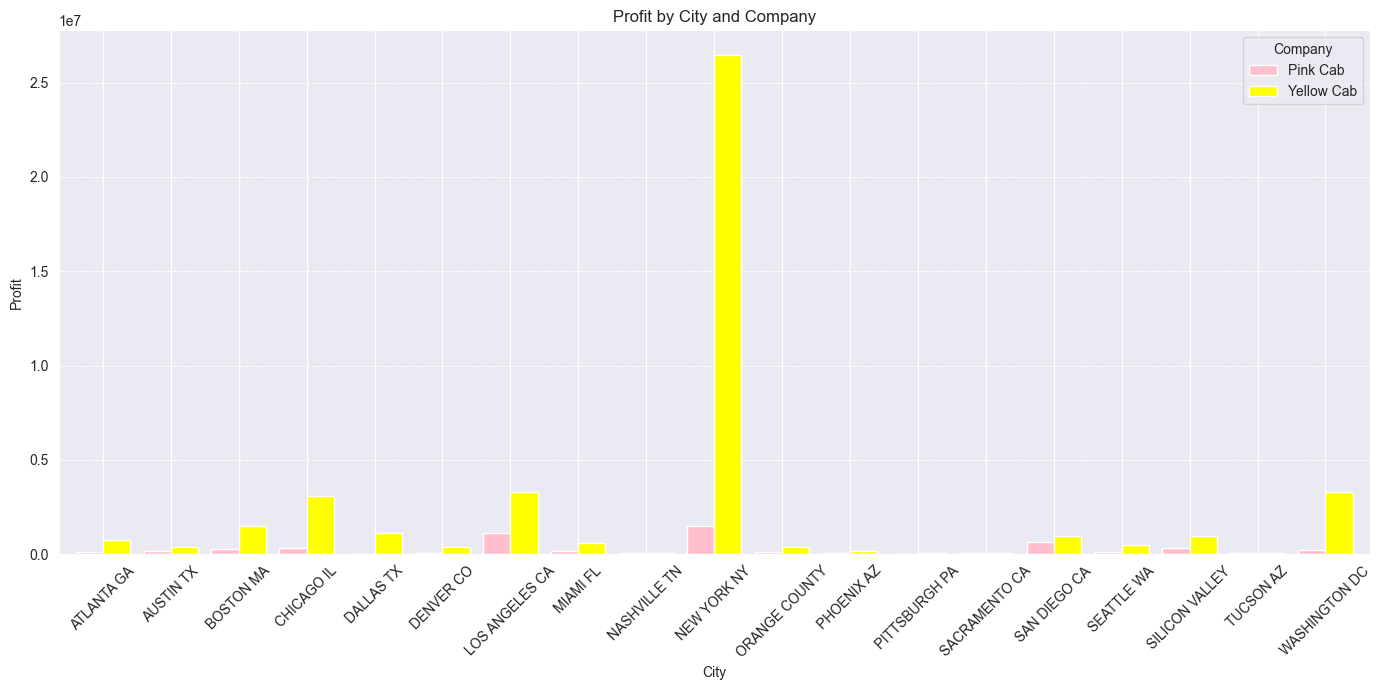

In [8]:
# Group data by 'City' and 'Company' and sum up the profits
city_company_profits = cab_data.groupby(['City', 'Company'])['Profit'].sum().unstack()

# Plotting the results
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
city_company_profits.plot(kind='bar', width=0.8, color=['pink', 'yellow'], ax=plt.gca())
plt.title('Profit by City and Company')
plt.xlabel('City')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Company')
plt.tight_layout()  # Adjust subplots to give some padding between them for axis labels
plt.show()

That is great, but the profits of Pink company are barely visible. In order to better see the distribution let us do it through the relative weight.

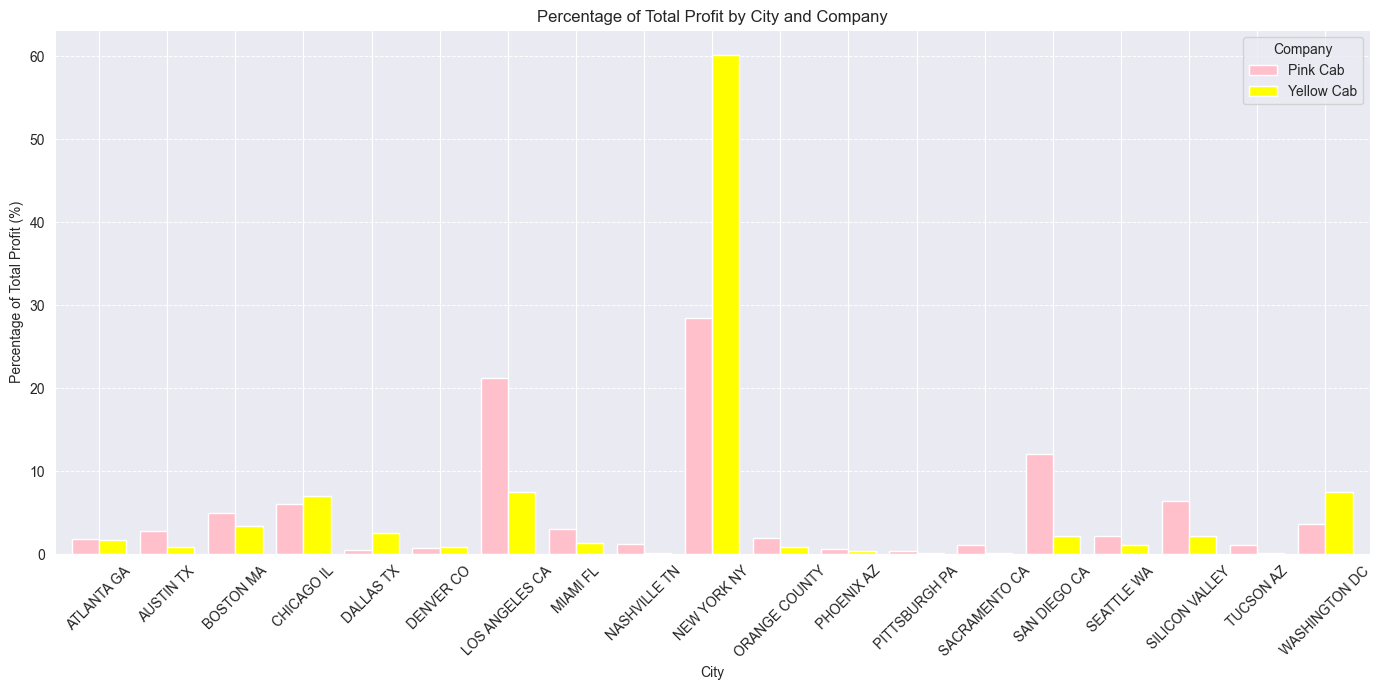

In [9]:
# Normalize profits by total profit for each company to get percentages
total_profits_by_company = city_company_profits.sum()
relative_city_profits = city_company_profits.divide(total_profits_by_company, axis=1) * 100

# Plotting the results
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
relative_city_profits.plot(kind='bar', width=0.8, color=['pink', 'yellow'], ax=plt.gca())
plt.title('Percentage of Total Profit by City and Company')
plt.xlabel('City')
plt.ylabel('Percentage of Total Profit (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Company')
plt.tight_layout()  # Adjust subplots to give some padding between them for axis labels
plt.show()

Now that is much better. We can make the following conclusions:
- 60% of profits of the Yellow Cab company are generated in New York;
- The Pink Company is much less dependent on the NY;
- However, the Pink Company has significant portion of its profits coming from the West Coast.

## Profit Forecast

We are going to use Holt-Winters Exponential Smoothing model to forecast our data. I believe it will yield the best results as our data is highly seasonal.

/Users/hm/PycharmProjects/G2MInsight/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hm/PycharmProjects/G2MInsight/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


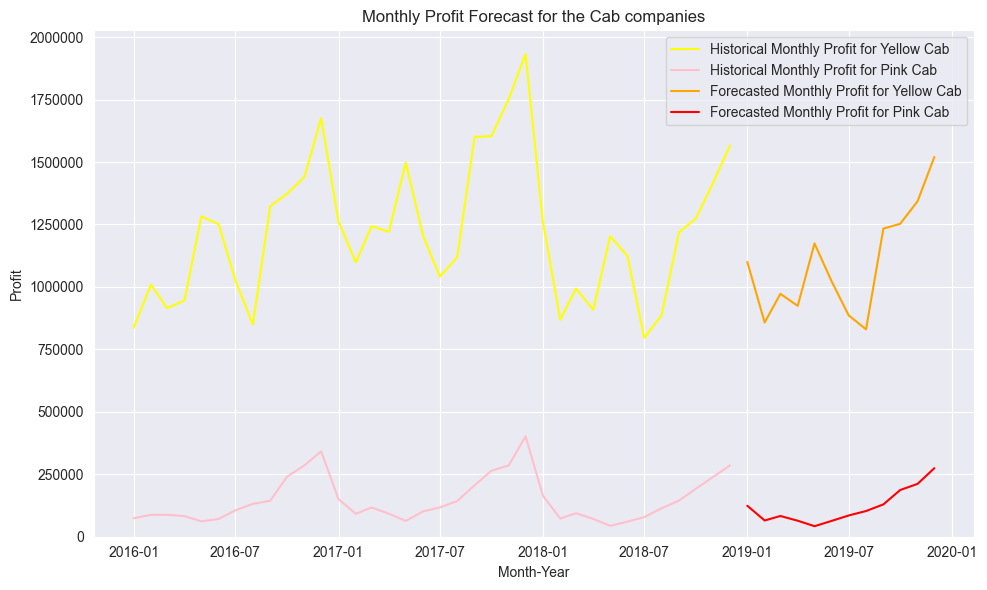

In [32]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming 'monthly_profit' is indexed by datetime and contains two columns ['Pink Cab', 'Yellow Cab'] for profits

# Ensure the index is in the correct datetime format
# monthly_profit.index = monthly_profit.index.to_timestamp()

# Fit a Holt-Winters model; here we use multiplicative if additive does not fit well
try:
    model1 = sm.tsa.ExponentialSmoothing(
        monthly_profit['Yellow Cab'],
        seasonal='mul',
        trend='add',
        seasonal_periods=12,
        initialization_method="estimated"
    ).fit()
    model2 = sm.tsa.ExponentialSmoothing(
        monthly_profit['Pink Cab'],
        seasonal='mul',
        trend='add',
        seasonal_periods=12,
        initialization_method="estimated"
    ).fit()
except ValueError as e:
    print("Error fitting model:", e)
    model1 = sm.tsa.ExponentialSmoothing(
        monthly_profit['Yellow Cab'],
        seasonal='mul',
        trend='add',
        seasonal_periods=12,
        initialization_method="heuristic"
    ).fit(smoothing_level=0.8, smoothing_trend=0.2, smoothing_seasonal=0.8)
    model2 = sm.tsa.ExponentialSmoothing(
        monthly_profit['Pink Cab'],
        seasonal='mul',
        trend='add',
        seasonal_periods=12,
        initialization_method="estimated"
    ).fit()

# Forecast the next 12 months
forecast1 = model1.forecast(12)
forecast2 = model2.forecast(12)

plt.figure(figsize=(10, 6))
plt.plot(monthly_profit['Yellow Cab'], label='Historical Monthly Profit for Yellow Cab', color='yellow')
plt.plot(monthly_profit['Pink Cab'], label='Historical Monthly Profit for Pink Cab', color='pink')
plt.plot(forecast1, label='Forecasted Monthly Profit for Yellow Cab', color='orange')
plt.plot(forecast2, label='Forecasted Monthly Profit for Pink Cab', color='red')
plt.title('Monthly Profit Forecast for the Cab companies')
plt.xlabel('Month-Year')
plt.ylabel('Profit')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))  
plt.tight_layout()
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.show()

## Customer Analysis

With that format sorted out, we can dive into the EDA. Let's start with analyzing Customer Data. What I would like to know is:
- how many customers are there?
- what are their gender, age, and income distributions?
- what is the most preferred way of payment?
- is there any relationship between these distributions?

Let's see if we can add the payment mode statistics to the customer analysis. We have to see how many unique users are in the transactions data. For each of them we have to assign a preferred payment method. After that, we would be allowed to merge the columns into a single table.

In [11]:
unique_customers_tran = np.unique(transaction_data['Customer ID'])
print("\nNumber of customers in transaction data: ", len(unique_customers_tran))

number_of_transactions = np.unique(transaction_data['Transaction ID'])
print("\nNumber of transactions: ", len(number_of_transactions))


Number of customers in transaction data:  49171

Number of transactions:  440098


As it turns out, we have exactly the same amount of users. We do not need to check their intersection, as it will be done by the JOIN command a bit later. Now, let's try to find out the probability of the users paying card (we will denote it with *p(card)*).

In [12]:
# Group by 'Customer ID' and 'Payment_Mode', then count each group
payment_mode_counts = transaction_data.groupby(['Customer ID', 'Payment_Mode']).size().unstack(fill_value=0)

payment_distribution_percent = transaction_data['Payment_Mode'].value_counts(normalize=True) * 100
print("\nPayment Distribution (Percentage):")
print(payment_distribution_percent)

# Calculate the probability of using 'Card' as payment mode
payment_mode_counts['p(card)'] = payment_mode_counts.get('Card', 0) / payment_mode_counts.sum(axis=1)

# Reset index to turn the indices into columns
payment_preferences = payment_mode_counts.reset_index()[['Customer ID', 'p(card)']]
print("\nPayment Preferences Preview:")
display(payment_preferences.head())


Payment Distribution (Percentage):
Payment_Mode
Card    59.984594
Cash    40.015406
Name: proportion, dtype: float64

Payment Preferences Preview:


Payment_Mode,Customer ID,p(card)
0,1,0.620690
1,2,0.625000
2,3,0.652174
3,4,0.653846
4,5,0.645161


In [13]:
# Merge the new payment preference data with the original customer data
customer_data = pd.merge(customer_data, payment_preferences, on='Customer ID', how='left')

# Display the first few rows to verify the merge
print("Enhanced Customer Data Preview:")
display(customer_data.head())

Enhanced Customer Data Preview:


,Customer ID,Gender,Age,Income (USD/Month),p(card)
0,29290,Male,28,10813,0.666667
1,27703,Male,27,9237,0.750000
2,28712,Male,53,11242,0.500000
3,28020,Male,23,23327,0.250000
4,27182,Male,33,8536,0.750000


In [14]:
# To answer the first question, we will count the unique customer IDs
unique_customers = customer_data['Customer ID'].nunique()
print(f"Number of unique customers: {unique_customers}")

Number of unique customers: 49171


In [15]:
# Analyze gender distribution with relative frequencies
gender_distribution_percent = customer_data['Gender'].value_counts(normalize=True) * 100
print("Gender Distribution (Percentage):")
print(gender_distribution_percent)

Gender Distribution (Percentage):
Gender
Male      54.019646
Female    45.980354
Name: proportion, dtype: float64


Age Distribution Summary:
count    49171.000000
mean        35.363121
std         12.599066
min         18.000000
25%         25.000000
50%         33.000000
75%         42.000000
max         65.000000
Name: Age, dtype: float64


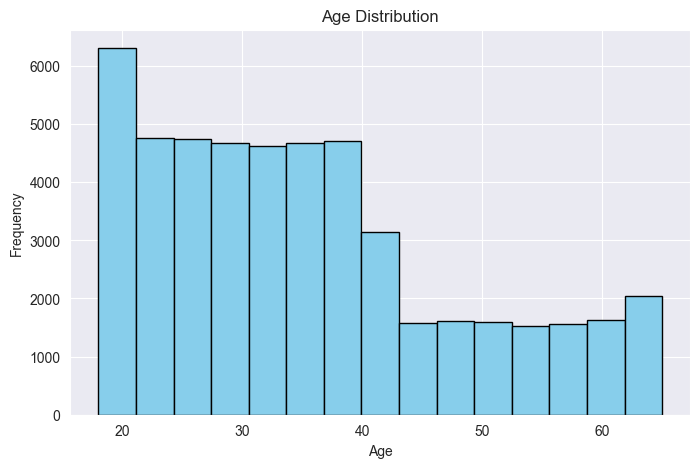

In [16]:
# Summary statistics for age
age_summary = customer_data['Age'].describe()
print("Age Distribution Summary:")
print(age_summary)

plt.figure(figsize=(8, 5))
plt.hist(customer_data['Age'], bins=15, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Income Distribution Summary:
count    49171.000000
mean     15015.631856
std       8002.208253
min       2000.000000
25%       8289.500000
50%      14656.000000
75%      21035.000000
max      35000.000000
Name: Income (USD/Month), dtype: float64


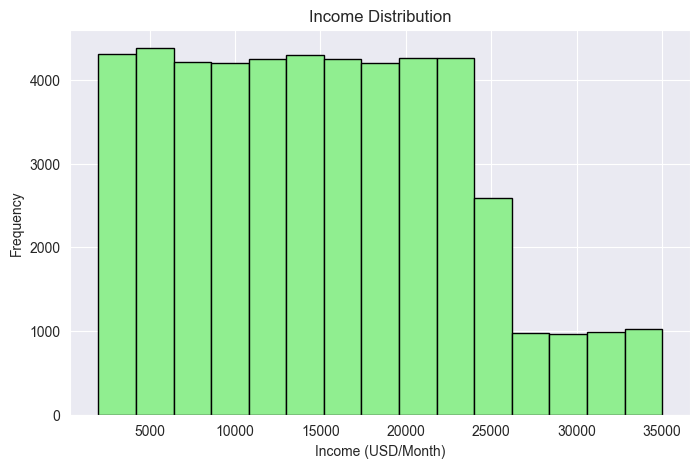

In [17]:
# Summary statistics for income
income_summary = customer_data['Income (USD/Month)'].describe()
print("Income Distribution Summary:")
print(income_summary)

# Histogram for income distribution
plt.figure(figsize=(8, 5))
plt.hist(customer_data['Income (USD/Month)'], bins=15, color='lightgreen', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income (USD/Month)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Correlation Matrix:
                         Age  Income (USD/Month)  Gender Encoded   p(card)
Age                 1.000000            0.000156       -0.004064  0.000477
Income (USD/Month)  0.000156            1.000000       -0.003408  0.007482
Gender Encoded     -0.004064           -0.003408        1.000000  0.003593
p(card)             0.000477            0.007482        0.003593  1.000000


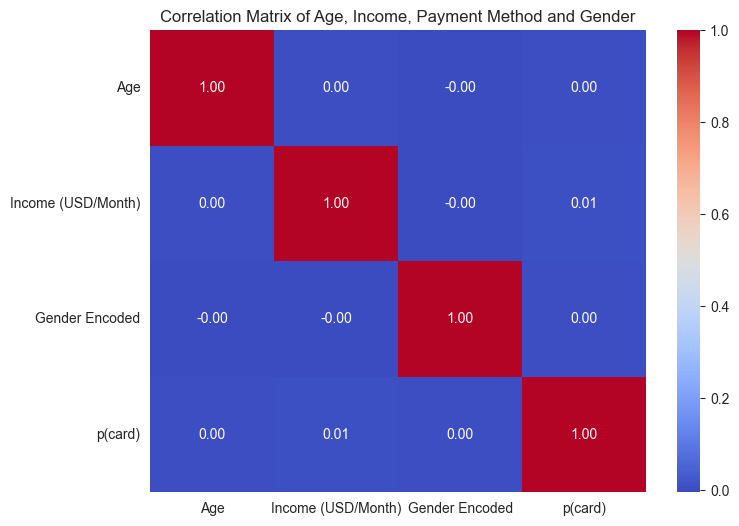

In [18]:
# Encoding gender as a numeric value
customer_data['Gender Encoded'] = customer_data['Gender'].map({'Male': 0, 'Female': 1})

# Compute the correlation matrix for age, income, and encoded gender
correlation_matrix = customer_data[['Age', 'Income (USD/Month)', 'Gender Encoded', 'p(card)']].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Age, Income, Payment Method and Gender')
plt.show()

Okay! I think that is a good result. We found out that:
- there are almost 50 thousands users;
- 54% of them are male, and 46% are female;
- 60% of the transactions were paid by card, and 40% by cash;
- majority of users are below age of 40 y.o.;
- most of the users earn below $25,000 a month, with the distribution being uniform;
- there is no correlation between any of the three metrics.

Even though this is cool information that we might use in the future, let us turn towards the most important part of analysis -- profitability of the companies.

### Company Analysis

As I have said, the biggest concern of investors is money. Therefore, we need to calculate the profit made by the companies with each transaction. 

In [19]:
# Calculate profit for each transaction
cab_data['Profit'] = cab_data['Price Charged'] - cab_data['Cost of Trip']

# Display the first few rows to verify the new 'Profit' column
print("Updated Cab Data Preview with Profit:")
display(cab_data.head())

Updated Cab Data Preview with Profit:


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Month-Year
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315,2016-01
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666,2016-01
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568,2016-01
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798,2016-01
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844,2016-01


Great! Now we can group the information about profit by the companies and years. Let's do this:

In [20]:
print(cab_data['Company'].unique())

['Pink Cab' 'Yellow Cab']
